<a href="https://colab.research.google.com/github/karalif-isavia/InfoSite/blob/main/Flaggspa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flaggspá - Breyting á uppsetningu gagna
Hér förum við yfir það hvernig breyta má flaggspágögnum úr því að líta svona út:

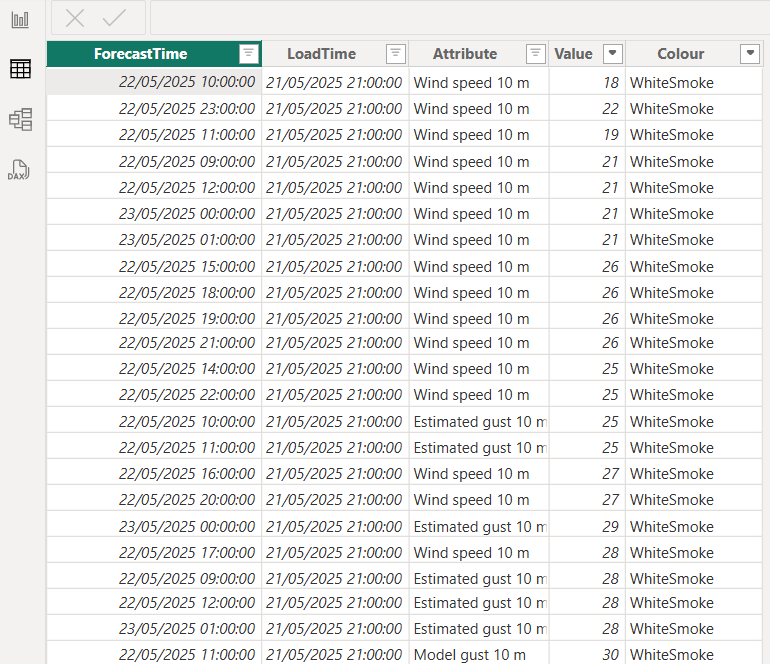

Í það að líta svona út:

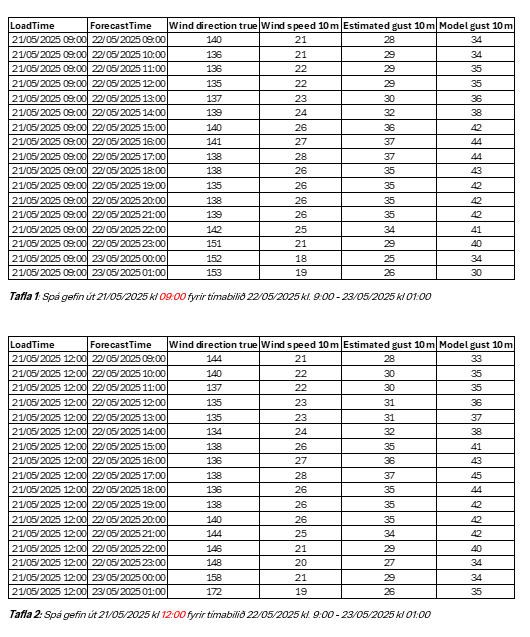


# Undirbúningur
- Til að byrja með þarf að undirbúa csv srá úr hráu gögnunum sem við munum svo vinna áfram með
- Í dæminu hér erum við að taka saman gögn úr flaggspánni þar sem
  - Forecast time:  22/05/2025 kl 8:30 - 23/05/2025 kl 01:00
  - Load time:      21/05/2025 kl. 9:00, 12:00, 15:00. 18:00 og 21:00
  - Attribute:      Model gust 10 m, Estimated gust 10 m, Wind speed 10 m, Wind direction true
- Hægt er að opna flaggspánna í annaðhvort PowerBI eða Excel með því að sækja þau í SQL gagnagrunn og fletta upp kf-dw01-prod server.
  - Þetta gefur upp lista af grunnum og sá sem við viljum skoða heitir dw_warehouse
- Til að byrja með líta gögnin svona út (skjáskot úr PowerBI):

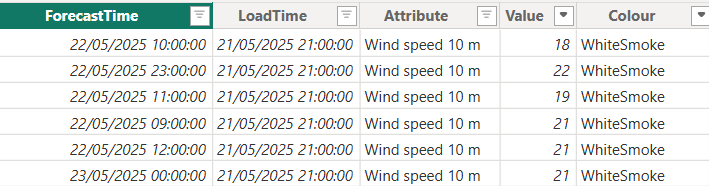

- Við filterum síðan gögnin eins og var tilgreint hér að ofan
- Þegar við erum sátt við skránna, exportum við henni í CSV. Þá ætti hún að líta svona út (Þar að segja ef hún er opnuð í VS Code eða sambærilegu tóli. Önnur tól gætu enn sýnt gögnin í dálkum sem er allt í lagi):

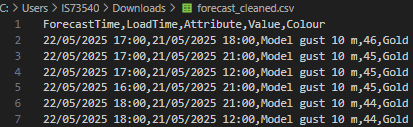

- Þegar þessi skrá er tilbúin er hægt að eiga við hana í þessu skjali hér.

# Leiðbeiningar
- Ýttu á play takkann á kassanum hér að neðan sem inniheldur scriptuna
- Skrollaðu á botninn á kassanum þar sem upp kemur takki sem stendur á "Choose File"
- Ýttu á hann og finndu forecast_cleaned.csv
- Þá keyrir scriptan aðeins og síðan downloadast sjálfkrafa annað skjal sem heitir forecast_final_grouped.csv
- Þetta er skjalið sem er búið að eiga við og ætti að líta svona út:

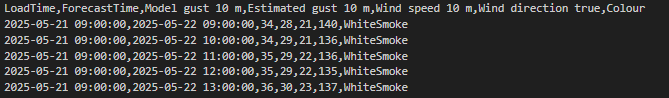

In [1]:
# Þetta eru pakkar sem þarf að installa til þess að ná að keyra scriptuna
import pandas as pd
from google.colab import files

# Skref 1: Hér köllum við á "Choose File" sem poppar upp að neðan svo hægt sé að velja skrá úr tölvunni
uploaded = files.upload()

# Skref 2: Hér lesum við fælinn sem er valinn.
df = pd.read_csv("forecast_cleaned.csv")

# Skref 3: Breytum attributes dálkinum í þessa fjóra dálka sem við vildum filtera
# Ef t.d. model gust var það sem við vorum að skoða í ákveðinni línu, kemur 1 í þann dálk en 0 í hina
attribute_columns = [
    "Model gust 10 m",
    "Estimated gust 10 m",
    "Wind speed 10 m",
    "Wind direction true"
]

for attr in attribute_columns:
    df[attr] = (df['Attribute'] == attr).astype(int)

# Skref 4: Svissum röðinni á ForecastTime og LoadTime
# Það er skýrara að loadTime sé fyrsti dálkurinn
df = df[['ForecastTime', 'LoadTime'] + attribute_columns + ['Value', 'Colour']]

cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index("LoadTime")))
cols.insert(1, cols.pop(cols.index("ForecastTime")))
df = df[cols]

# Skref 6: Flokkum LoadTime í tímaröð
df["LoadTime"] = pd.to_datetime(df["LoadTime"], dayfirst=True, errors='coerce')
df = df.sort_values(by="LoadTime", ascending=False)

# Skref 7: Hér skiptum við út 1 fyrir það value sem á heima í dálkinum (sjá skref 3)
for attr in attribute_columns:
    df[attr] = df.apply(lambda row: row["Value"] if row[attr] == 1 else 0, axis=1)

# Skref 8: Nú má eyða value dálkinum því við erum búin að setja það gildi á réttan stað
df.drop(columns=["Value"], inplace=True)

# Skref 9: Flokkum nú ForecastTime og sameinum línur sem eru eins. T.d. ef við erum með:

# LoadTime,ForecastTime,Model gust 10 m,Estimated gust 10 m,Wind speed 10 m,Wind direction true,Colour
# 2025-05-21 09:00:00,2025-05-22 23:00:00,40,0,0,0,WhiteSmoke
# 2025-05-21 09:00:00,2025-05-22 23:00:00,0,29,0,0,WhiteSmoke
# 2025-05-21 09:00:00,2025-05-22 23:00:00,0,0,21,0,WhiteSmoke
# 2025-05-21 09:00:00,2025-05-22 23:00:00,0,0,0,151,

# Þá viljum við sameina það í eina línu:

# 2025-05-21 09:00:00,2025-05-22 23:00:00,40,29,21,151,WhiteSmoke

df["ForecastTime"] = pd.to_datetime(df["ForecastTime"], dayfirst=True, errors='coerce')

grouped = df.groupby(["LoadTime", "ForecastTime"], as_index=False).agg({
    "Model gust 10 m": "max",
    "Estimated gust 10 m": "max",
    "Wind speed 10 m": "max",
    "Wind direction true": "max",
    "Colour": lambda x: next((val for val in x if pd.notna(val) and val != ""), "")
})

# Skref 11: Vistum niðurstöðurnar í nýja csv skrá
output_file = "forecast_final_grouped.csv"
grouped.to_csv(output_file, index=False)

# Skref 12: Niðurhal á lokaniðurstöðunni
files.download(output_file)


Saving forecast_cleaned.csv to forecast_cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Þegar hingað er komin erum við komin með gögnin á því formati sem við viljum hafa það. Hér er smá tilraun til að sýna það:

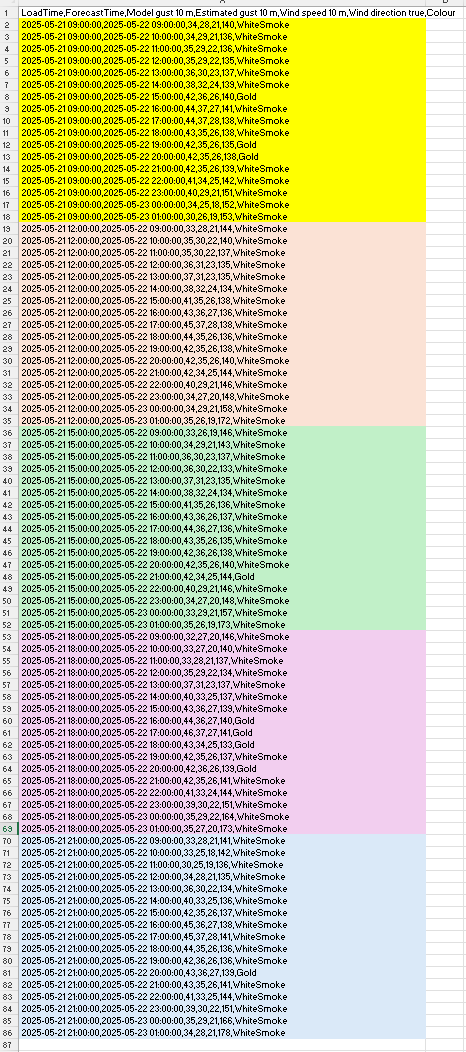

- Hér er búið að litaflokka gögnin eftir forecastTime. Guli liturinn eru gögnin kl 09:00, bleiki eru gögnin kl 12:00 osfrv.
- Til þess að fá gögnin í töflu format aftur er hægt að fylgja eftirfarandi skrefum:
  - Smella á dálkinn sem öll gögnin eru í
  - Data -> Text to columns
  - Veljum Delimited, Next
  - Veljum Comma sem delimeter, Finish

Þá erum við komin með gögnin svona og við getum sett þau upp eins og við viljum:

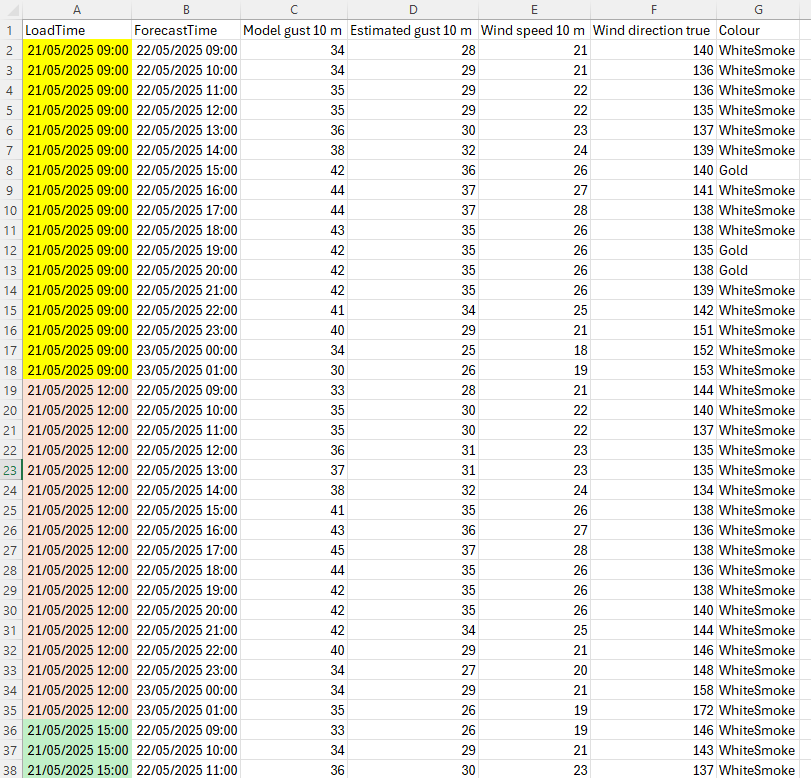

# Lokaniðurstaða

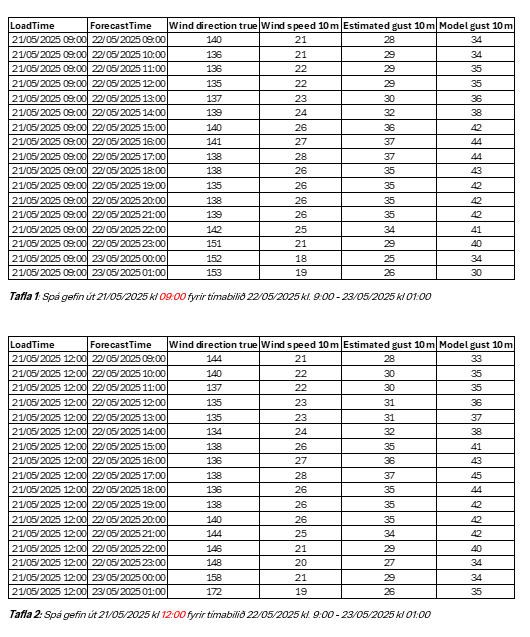